# Imports

In [17]:
import pandas as pd
import numpy as np
import sklearn

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures,StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

# Load Data

In [5]:
df = pd.read_csv("../data/kaggle_toy.csv")
df.head().T

,0,1,2,3,4
id,0,1,2,3,4
Podcast_Name,Mystery Matters,Joke Junction,Study Sessions,Digital Digest,Mind & Body
Episode_Title,Episode 98,Episode 26,Episode 16,Episode 45,Episode 86
Episode_Length_minutes,NaN,119.8,73.9,67.17,110.51
Genre,True Crime,Comedy,Education,Technology,Health
Host_Popularity_percentage,74.81,66.95,69.97,57.22,80.07
Publication_Day,Thursday,Saturday,Tuesday,Monday,Monday
Publication_Time,Night,Afternoon,Evening,Morning,Afternoon
Guest_Popularity_percentage,NaN,75.95,8.97,78.7,58.68
Number_of_Ads,0.0,2.0,0.0,2.0,3.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           10000 non-null  int64  
 1   Podcast_Name                 10000 non-null  object 
 2   Episode_Title                10000 non-null  object 
 3   Episode_Length_minutes       8825 non-null   float64
 4   Genre                        10000 non-null  object 
 5   Host_Popularity_percentage   10000 non-null  float64
 6   Publication_Day              10000 non-null  object 
 7   Publication_Time             10000 non-null  object 
 8   Guest_Popularity_percentage  8008 non-null   float64
 9   Number_of_Ads                10000 non-null  float64
 10  Episode_Sentiment            10000 non-null  object 
 11  Listening_Time_minutes       10000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 937.6+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10000.0,4999.500000,2886.895680,0.000000,2499.750000,4999.50000,7499.250000,9999.00
Episode_Length_minutes,8825.0,64.798698,33.103045,5.000064,35.830000,64.18000,94.450000,119.96
Host_Popularity_percentage,10000.0,59.940578,22.933476,20.000000,39.390000,60.08000,79.660000,99.96
Guest_Popularity_percentage,8008.0,51.662475,28.302334,0.030000,27.770000,52.71500,75.620000,107.08
Number_of_Ads,10000.0,1.348500,1.101621,0.000000,0.000000,1.00000,2.000000,3.00
Listening_Time_minutes,10000.0,45.695784,27.268595,0.000000,23.518887,43.60077,64.996592,119.97


Insight:
1. id to be removed
2. Podcast_Name, check if can be used for imputation of Guest_Popularity_percentage, Episode_Length_minutes
3. Missing values in Guest_Popularity_percentage, Episode_Length_minutes
4. Check outliers in  Guest_Popularity_percentage, why is it 107.08

In [8]:
df.shape

(10000, 12)

In [9]:
to_drop = ["Listening_Time_minutes", 'id', 'Podcast_Name', 'Episode_Title']

X = df.drop(to_drop, axis=1)
y = df["Listening_Time_minutes"]


print(X.shape, y.shape)

(10000, 8) (10000,)


In [10]:
df.columns

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')

In [ ]:
numerical_col = ['Episode_Length_minutes','Host_Popularity_percentage', "Guest_Popularity_percentage",]
categorical_col = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment','Number_of_Ads']

# 2. Data Visualization

In [12]:
# Univariate

# Target visualization
# Features:
# Categorical - Countplot
# Numerical - Histogram with KDE

<Axes: xlabel='Listening_Time_minutes', ylabel='Count'>

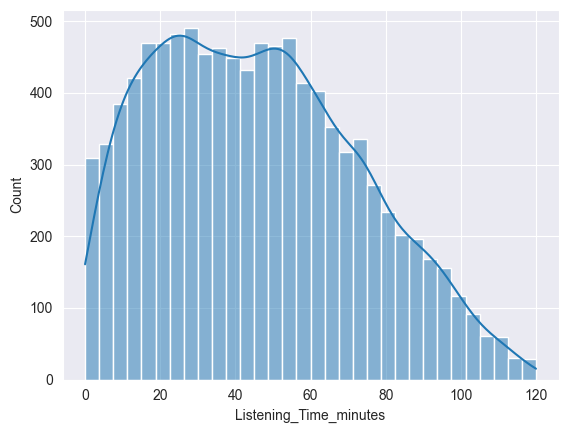

In [13]:
sns.histplot(y, kde=True)

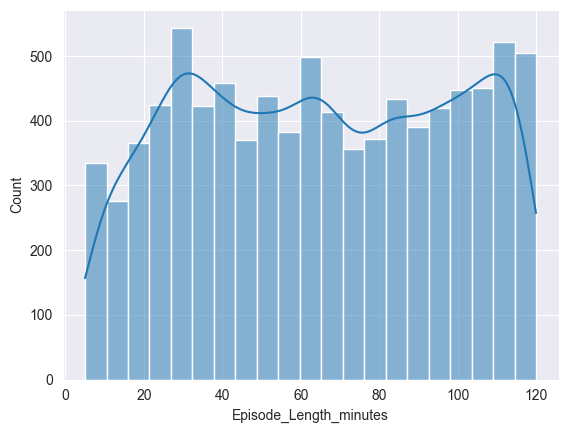

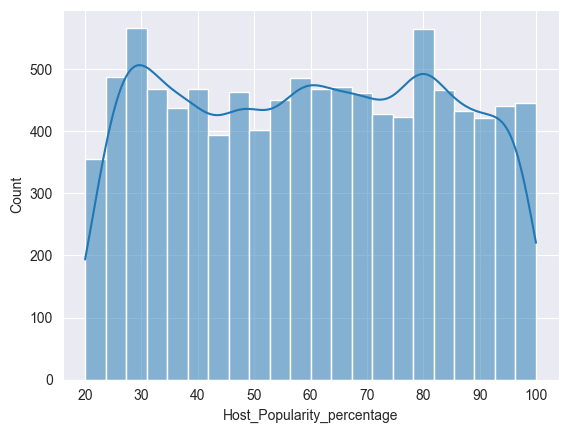

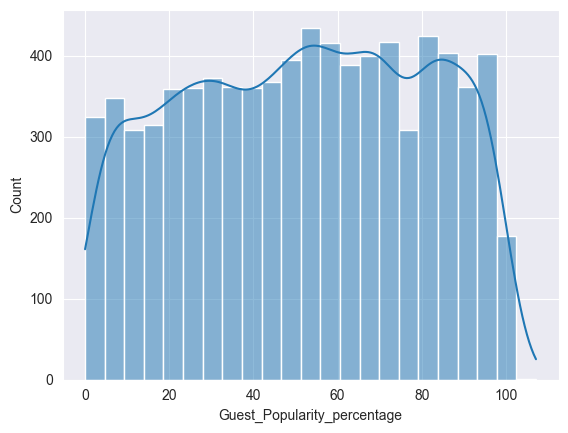

In [14]:
for col in numerical_col:
    sns.histplot(X[col], kde=True)
    plt.show()

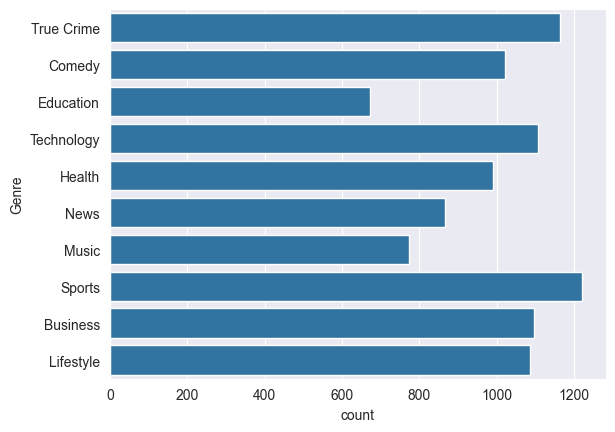

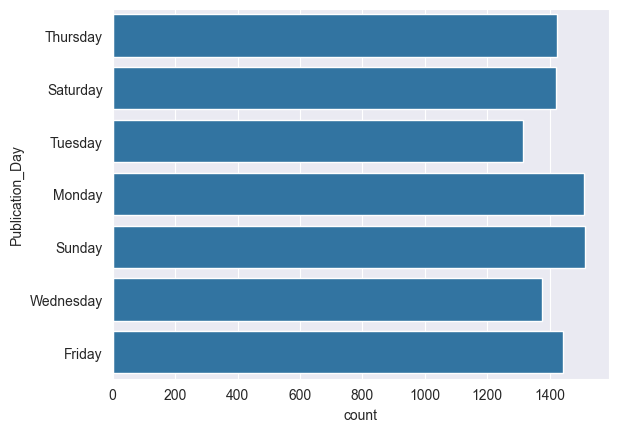

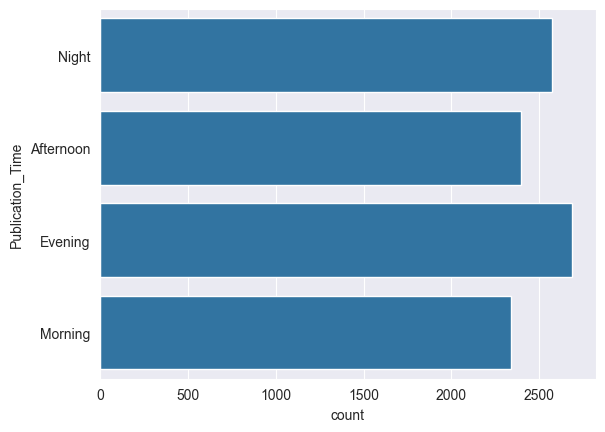

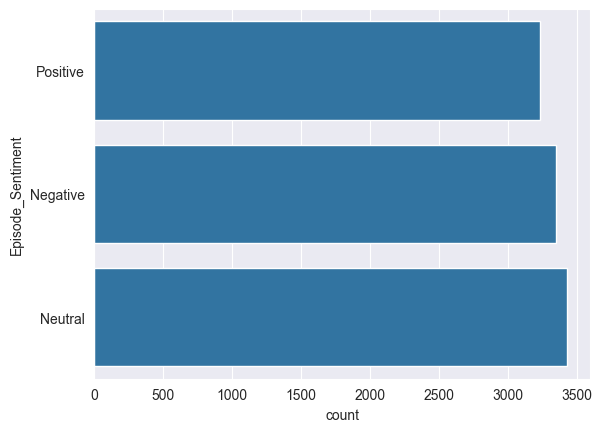

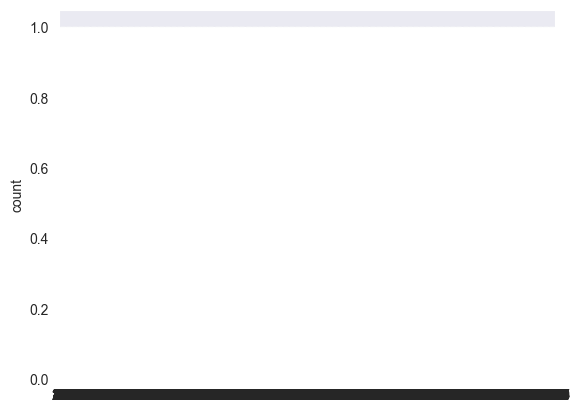

In [15]:
for col in categorical_col:
    sns.countplot(X[col])
    plt.show();

# 3. Feature Engineering

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state= 42)

print(X_train.shape, X_test.shape)

(8000, 8) (2000, 8)


In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Episode_Length_minutes       8825 non-null   float64
 1   Genre                        10000 non-null  object 
 2   Host_Popularity_percentage   10000 non-null  float64
 3   Publication_Day              10000 non-null  object 
 4   Publication_Time             10000 non-null  object 
 5   Guest_Popularity_percentage  8008 non-null   float64
 6   Number_of_Ads                10000 non-null  float64
 7   Episode_Sentiment            10000 non-null  object 
dtypes: float64(4), object(4)
memory usage: 625.1+ KB


In [36]:
X

,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive
1,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative
2,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative
3,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive
4,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral
...,...,...,...,...,...,...,...,...
9995,100.09,Business,95.05,Thursday,Afternoon,29.69,1.0,Positive
9996,107.40,Lifestyle,43.68,Wednesday,Evening,99.26,3.0,Neutral
9997,23.38,Comedy,99.43,Monday,Morning,NaN,2.0,Negative
9998,33.61,Health,68.36,Saturday,Afternoon,NaN,2.0,Neutral


In [60]:
# Process numerical data -> Missingness

num_pipeline = Pipeline([
    ("impute", SimpleImputer()),
])

feat_transformer = ColumnTransformer([
    ("impute", num_pipeline, ["Guest_Popularity_percentage", "Episode_Length_minutes"]),
    ("log_trans", FunctionTransformer(func = np.square), ["Guest_Popularity_percentage"]),
    ("scaling", StandardScaler())
    ("ohe", OneHotEncoder(sparse_output=False, drop = "first"), categorical_col),
])

feat_transformer.set_output(transform = "pandas")

X_train_1 = feat_transformer.fit_transform(X_train)
X_test_1 = feat_transformer.transform(X_test)

print(X_train_1.shape, X_test_1.shape)

<>:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
C:\Users\alien\AppData\Local\Temp\ipykernel_3144\1755359900.py:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ("scaling", StandardScaler())


TypeError: 'tuple' object is not callable

In [59]:
X_train_1

,impute__Guest_Popularity_percentage,impute__Episode_Length_minutes,ohe__Genre_Comedy,ohe__Genre_Education,ohe__Genre_Health,ohe__Genre_Lifestyle,ohe__Genre_Music,ohe__Genre_News,ohe__Genre_Sports,ohe__Genre_Technology,ohe__Genre_True Crime,ohe__Publication_Day_Monday,ohe__Publication_Day_Saturday,ohe__Publication_Day_Sunday,ohe__Publication_Day_Thursday,ohe__Publication_Day_Tuesday,ohe__Publication_Day_Wednesday,ohe__Publication_Time_Evening,ohe__Publication_Time_Morning,ohe__Publication_Time_Night,ohe__Episode_Sentiment_Neutral,ohe__Episode_Sentiment_Positive,ohe__Number_of_Ads_1.0,ohe__Number_of_Ads_2.0,ohe__Number_of_Ads_3.0
9254,0.255286,-1.389006,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1561,0.506002,-0.665243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1670,0.560878,0.249401,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
6087,-1.536809,1.005139,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6669,0.124601,-0.547866,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,-0.243494,0.912306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5191,0.259818,0.249401,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5390,0.259818,1.130933,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,-0.883410,-0.504250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
